1. **데이터 전처리 개선**: 
   - **이미지 전처리**: OCR 성능은 입력 이미지의 품질에 크게 의존합니다. 노이즈 제거, 이진화, 명암 조정, 사이즈 정규화 등의 이미지 전처리 기법을 최적화하여 이미지의 품질을 개선할 수 있습니다.
   - **데이터 증강(augmentation)**: 훈련 데이터에 다양한 변형을 적용하여 모델의 일반화 능력을 향상시킵니다. 예를 들어, 회전, 스케일 변경, 밝기 조절, 잘림(cropping) 등을 사용할 수 있습니다.

2. **포스트 프로세싱 최적화**:
   - **문자 후처리**: 인식된 문자열에 대한 후처리를 통해 오탈자를 수정하거나, 단어의 경계를 더 정확히 파악할 수 있습니다. 예를 들어, 언어 모델을 사용하여 가장 가능성 있는 단어로 교정할 수 있습니다.
   - **연결 규칙**: 여러 개의 인식된 문자 또는 단어를 올바른 순서대로 연결하는 규칙을 최적화할 수 있습니다.

3. **하이퍼파라미터 튜닝**:
   - 학습률, 배치 크기, 손실 함수의 가중치 등 다양한 하이퍼파라미터를 조정하여 성능을 개선할 수 있습니다.

4. **손실 함수 조정**:
   - OCR의 경우, 문자 검출과 문자 인식을 위한 손실 함수의 균형이 중요합니다. 각 부분의 가중치를 조정하여 모델의 성능을 향상시킬 수 있습니다.

5. **학습 스케줄 조정**:
   - 학습률 감소(lr decay), 워밍업(warm-up) 기간 설정 등을 통해 학습 과정을 더욱 효율적으로 만들 수 있습니다.

6. **앙상블 기법**:
   - 여러 모델의 결과를 결합하여 더 나은 성능을 달성할 수 있습니다. 단, 모델 자체를 변경할 수 없다면 같은 모델의 다양한 버전(예: 다른 하이퍼파라미터, 훈련 에포크 등)을 앙상블로 사용할 수 있습니다.

7. **평가 방법 점검**:
   - 훈련된 모델의 성능을 평가하는 방법을 점검하여 실제 테스트 환경과 가장 유사하게 평가하는지 확인합니다. 잘못된 평가 방법은 실제 성능을 왜곡시킬 수 있습니다.

In [1]:
# 필요한 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 이미지 데이터셋 로드
data_path = '../data/medical/img/train'
image_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.jpg')]
images = [cv2.imread(path) for path in image_paths]

In [3]:
# 이미지 시각화 함수
def plot_images(images, titles=None, cols=4, cmap=None):
    rows = len(images) // cols + 1
    plt.figure(figsize=(cols * 2, rows * 2))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap=cmap)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

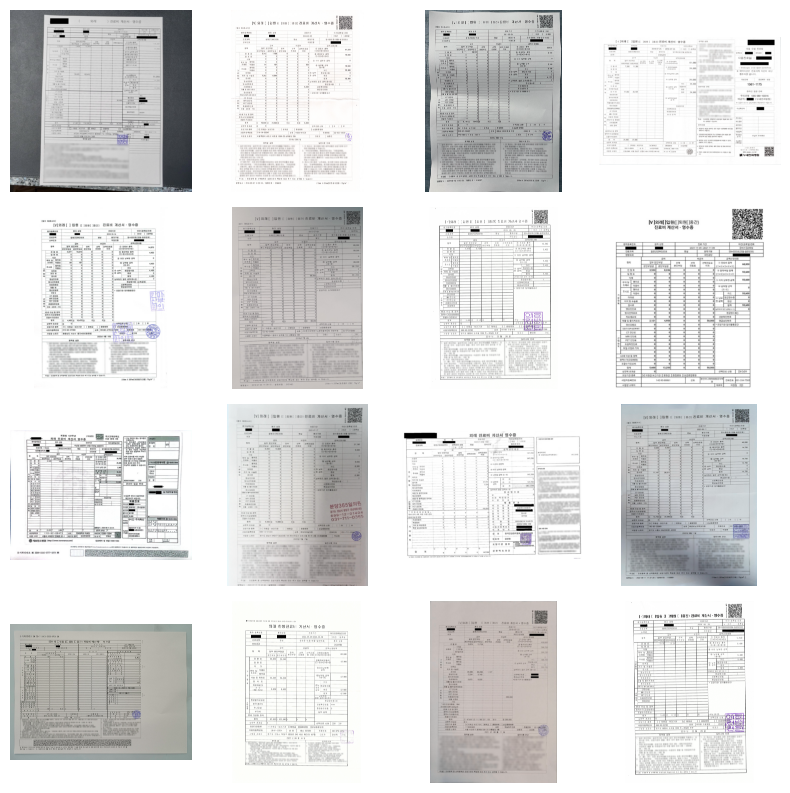

In [4]:
# 이미지 샘플 시각화
plot_images(images[:16])


In [5]:
# 이미지 속성 분석
image_shapes = [img.shape for img in images]
df_shapes = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


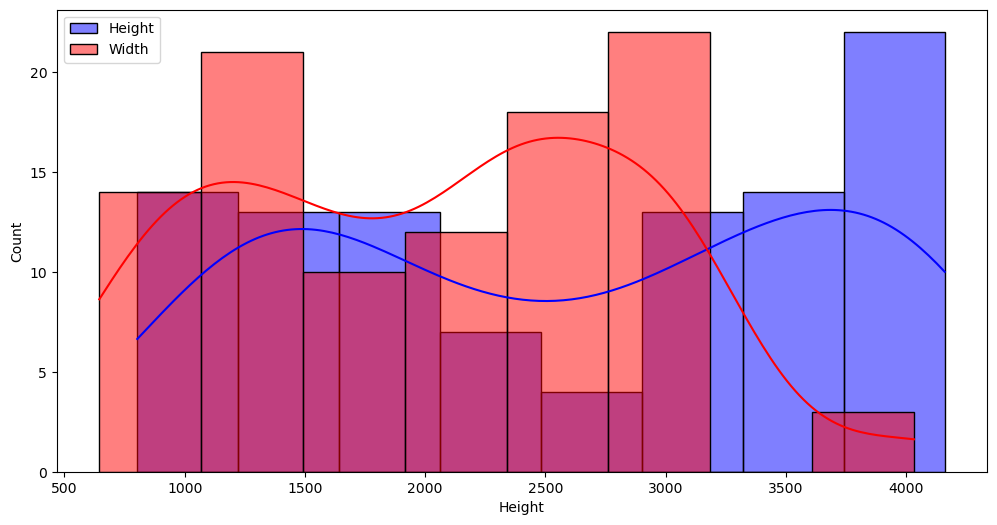

In [6]:
# 이미지 크기 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data=df_shapes, x='Height', kde=True, color='blue', label='Height')
sns.histplot(data=df_shapes, x='Width', kde=True, color='red', label='Width')
plt.legend()
plt.show()

In [7]:
# JSON 파일 로드
with open('../data/medical/ufo/train.json', 'r') as file:
    data = json.load(file)

In [8]:
# 텍스트 데이터 추출
text_data = []
for image, content in data['images'].items():
    for word_id, word_info in content['words'].items():
        text_data.append(word_info['transcription'])

In [9]:
# 텍스트 길이 계산
text_lengths = [len(text) for text in text_data]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


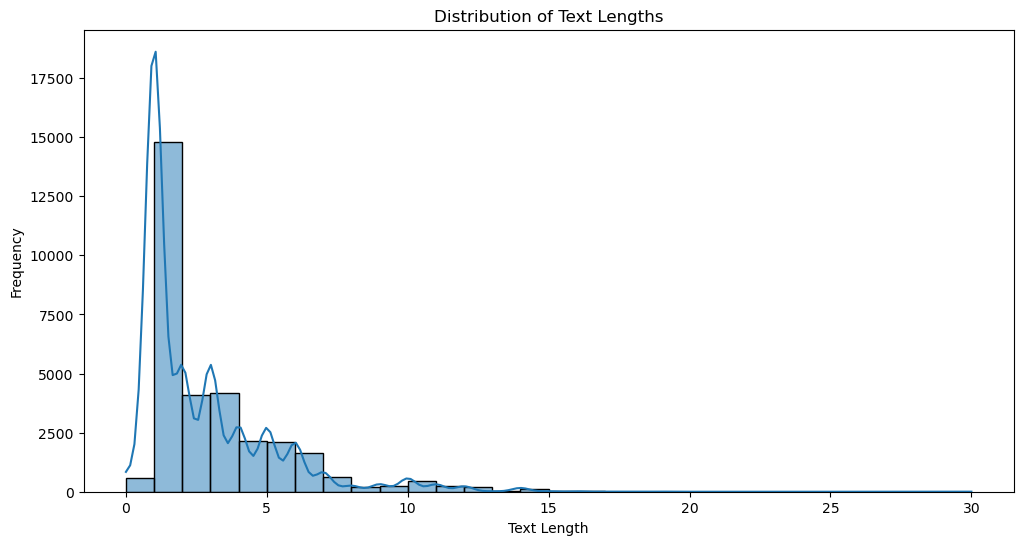

In [10]:
# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
# 텍스트 위치 및 방향 데이터 추출
orientations = []
x_coords = []
y_coords = []
for image, content in data['images'].items():
    for word_id, word_info in content['words'].items():
        # 방향 데이터 추가
        orientations.append(word_info['orientation'])

        # 위치 데이터 추출 및 평균 계산
        points = word_info['points']
        x_mean = sum(point[0] for point in points) / len(points)
        y_mean = sum(point[1] for point in points) / len(points)
        x_coords.append(x_mean)
        y_coords.append(y_mean)

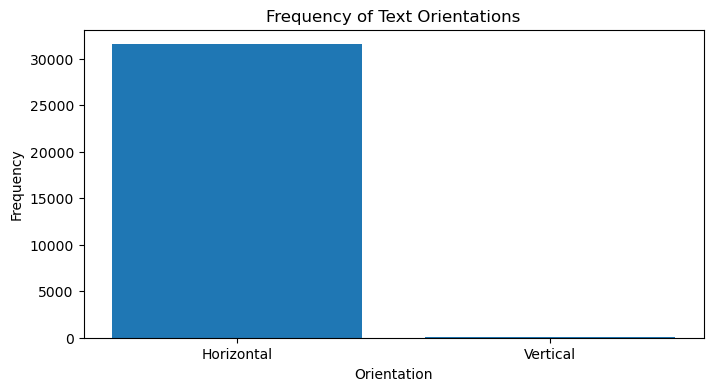

In [12]:
# orientations 리스트의 빈도수 계산
orientation_counts = Counter(orientations)

# 바 차트로 시각화
plt.figure(figsize=(8, 4))
plt.bar(orientation_counts.keys(), orientation_counts.values())

plt.title('Frequency of Text Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')
plt.show()

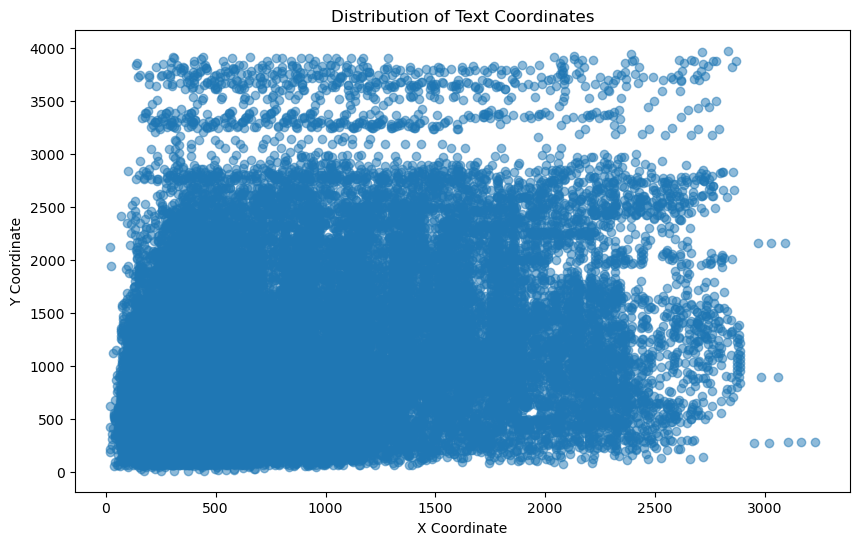

In [13]:
# 텍스트 위치 분포 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, alpha=0.5)
plt.title('Distribution of Text Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()